# Weekly assignment 7: Improving the discretized solution

In this exercise you will make several improvements to the cake
eating code in the lecture 7, part 2, to make the solution even
more accurate.

## Task 1. Base solution

Copy the version of the cake eating code (with discretized choices)
from the lecture slides and modify if needed to to ensure:

- There are two separate grids for state $ W_t $ and choice $ c_t $.  
- The grids for states and choices are initialized at the time the object is created,
  and do not change when the Bellman equation is solved.  


Debug the code and produce the convergence plots as in the lecture.

In [1]:
# write your code here
# come up with a test of your own

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate

class cake_discretized():
    def __init__(self,beta=.9, Wbar=10, ngrid_state=50, ngrid_choice=100):
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on cake size
        self.ngrid_state = ngrid_state  # Number of grid points for the size of cake
        self.ngrid_choice = ngrid_choice  # Number of grid points for how much of cake to consume
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid_state = np.linspace(self.epsilon,Wbar,ngrid_state) # grid for state space
        self.grid_choice = np.linspace(self.epsilon,Wbar,ngrid_choice) # grid for decision space
        self.interpolation = 'linear' # interpolation type for Bellman equation
        self.choice_bound = False # impose the state bound on the trial values of choice or not
    def bellman(self,V0):
        #Bellman operator, V0 is one-dim vector of values on grid
        matW = np.repeat(np.reshape(self.grid_state,(1,-1)),self.ngrid_choice,0) # matrix with state space repeated in rows
        c = np.repeat(np.reshape(self.grid_choice,(-1,1)),self.ngrid_state,1) # decisions grid repeated by columns
        if self.choice_bound: c *= np.reshape(self.grid_state,(1,-1)) /self.Wbar # normalize max choice to current wealth
        matWpr = matW-c # size of cake in the next period
        matWpr[matWpr==0] = self.epsilon # add small quantity to avoid log(0)
        mask = matWpr>0 # mask off infeasible choices
        # interpolation kind
        if self.interpolation=='linear':
            interfunc = interpolate.interp1d(self.grid_state,V0,kind='slinear',fill_value="extrapolate")
        elif self.interpolation=='quadratic':
            interfunc = interpolate.interp1d(self.grid_state,V0,kind='quadratic',fill_value="extrapolate")
        elif self.interpolation=='cubic':
            interfunc = interpolate.interp1d(self.grid_state,V0,kind='cubic',fill_value="extrapolate")
        elif self.interpolation=='polynomial':
            p = np.polynomial.polynomial.polyfit(self.grid_state,V0,self.ngrid_state-1)
            interfunc = lambda x: np.polynomial.polynomial.polyval(x,p)
        else:
            print('Unknown interpolation type')
            return None
        # INPERPOLATE values of next period value at next period case sizes
        matV1 = interfunc(matWpr)
        preV1 = np.full((self.ngrid_choice,self.ngrid_state),-np.inf) # init V with -inf
        preV1[mask] = np.log(c[mask]) + self.beta*matV1[mask] # maximand of the Bellman equation
        V1 = np.amax(preV1,0,keepdims=False) # maximum in every column
        c1 = c[np.argmax(preV1,axis=0),range(self.ngrid_state)] # choose the max attaining levels of c
        return V1, c1
    def solve(self, maxiter=1000, tol=1e-4, callback=None, interpolation='linear', choice_bound = False):
        '''Solves the model using successive approximations'''
        self.interpolation = interpolation # update solver settings
        self.choice_bound = choice_bound
        V0=np.log(self.grid_state) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1=self.bellman(V0)
            if callback: callback(iter,self.grid_state,V1,c1) # callback for making plots
            if np.all(abs(V1-V0) < tol):
                break
            V0=V1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return V1,c1

In [13]:
m = cake_discretized(beta=0.92,Wbar=10,ngrid_state=50,ngrid_choice=50)
V,c = m.solve()

print(V)

[-450.54456873 -416.09015055 -384.39208582 -355.22986627 -328.40062428
 -303.71772165 -281.00945124 -260.11784245 -240.89756237 -223.21490469
 -206.94685963 -191.98025818 -178.21098484 -165.54325337 -153.88894041
 -143.16697249 -133.30276201 -124.22768836 -115.87862061 -108.19747827
 -101.13082733  -94.62950845  -88.64829509  -83.1455788   -78.08307981
  -73.42558074  -69.1406816   -65.19857438  -61.57183575  -58.2352362
  -55.16556462  -52.34146677  -49.74329674  -47.35298031  -45.1538892
  -43.13072538  -41.26941467  -39.55700881  -37.98159542  -36.5322151
  -35.19878521  -33.9720297   -32.84341464  -31.80508878  -30.849829
  -29.97098999  -29.16245811  -28.41860877  -27.72546159  -27.04112021]


## Task 2. Accuracy measure

Modify the function that compares the numerical solution to the analytical so
that it outputs a measure of accuracy equal to the average of squared deviations over
a fixed dense grid. Also provide an argument to disable the plot for Task 5.

In [4]:
# write your code here

In [5]:
def accuracy(model,V=None,policy=None,title='',npoints=1000,plot=True):
    '''Check the cake eating numerical solution against the analytic solution'''
    # analytic solution
    aV = lambda w: np.log(w)/(1 - model.beta) + np.log(1 - model.beta)/(1 - model.beta) + model.beta* np.log(model.beta)/((1 - model.beta)**2)
    aP = lambda w: (1 - model.beta) * w
    if 'cake_ongrid' in str(type(model)):
        grid = model.grid
    else:
        grid = model.grid_state
    # solve if needed
    if V is None or policy is None:
        V,policy = model.solve()
    # accuracy measure
    xd = np.linspace(grid[0],grid[-1],npoints) # dense grid for accuracy measure
    ac = ((aV(xd)-np.interp(xd,grid,V))**2).mean()
    # make plots
    if plot:
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value functions')
        ax2.set_title('Policy functionas')
        ax1.set_xlabel('Cake size, W')
        ax2.set_xlabel('Cake size, W')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        ax1.plot(grid[1:],V[1:],linewidth=1.5,label='Numerical')
        ax1.plot(grid[1:],aV(grid[1:]),linewidth=1.5,label='Analytical')
        ax2.plot(grid,policy,linewidth=1.5,label='Numerical')
        ax2.plot(grid,aP(grid),linewidth=1.5,label='Analytical')
        ax1.legend()
        ax2.legend()
        fig1.suptitle(title)
        plt.show()
    return ac

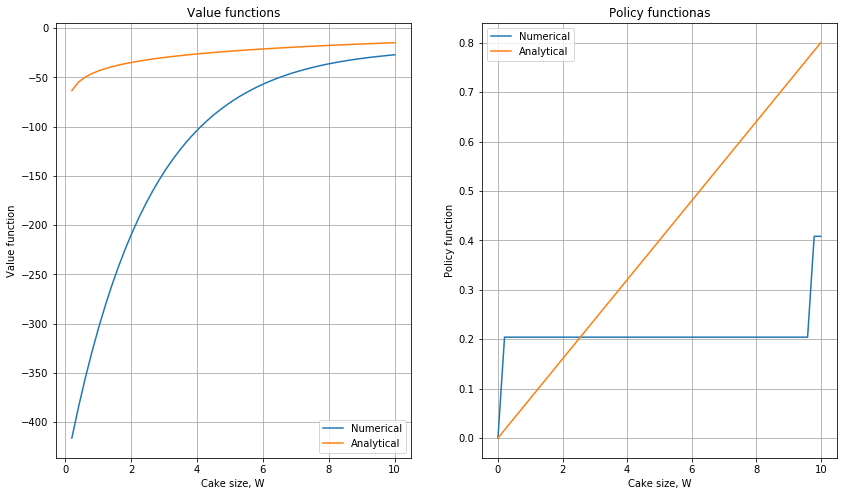

Accuracy of the basic solution is 18673.53388908259


In [6]:
ac0=accuracy(m,V=V,policy=c)
print('Accuracy of the basic solution is',ac0)

## Task 3. Bounding the choice grid

Modify the Bellman equation code to make the choice discretization grid dependent
on the point of the state space where it is applied to, namely make the grid with
the same number of points going from $ 0 $ to $ \vec{W}_j $ when solving
at the point $ \vec{W}_j $, instead of from $ 0 $ to $ \bar{W} $.

Repeat the accuracy check in Task 2 with the new specification.

In [7]:
# write your code here

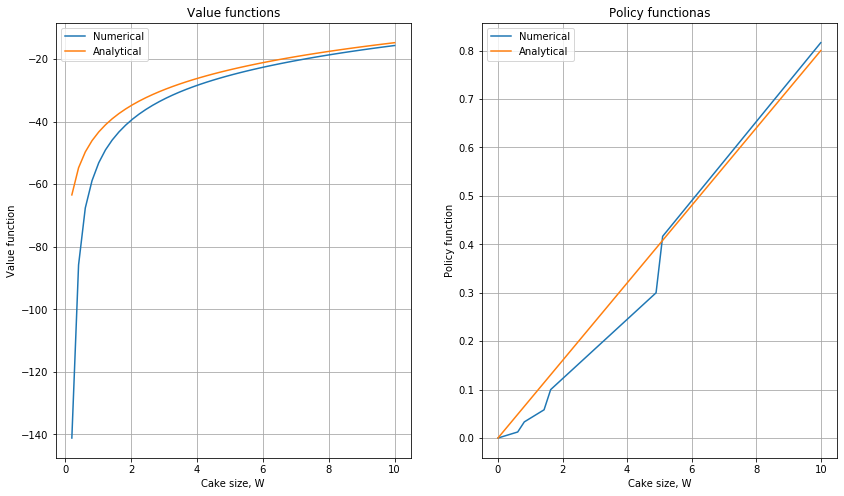

Accuracy of the method with bound on choices is 1155.1284306808527 instead of 18673.53388908259


In [8]:
V,c = m.solve(choice_bound=True)
ac1=accuracy(m,V=V,policy=c)
print('Accuracy of the method with bound on choices is',ac1,'instead of',ac0)

## Task 4. Improving interpolation method

We could utilize more advanced interpolation schemes for the value function itself.

Replace linear interpolation of the value function with quadratic and cubic splines, and approximating
polynomials.

Compare the accuracy of the new two versions to the original solution and the solution
with the improvement from task 3.

What is the most accurate solution algorithm?

In [9]:
# write your code here

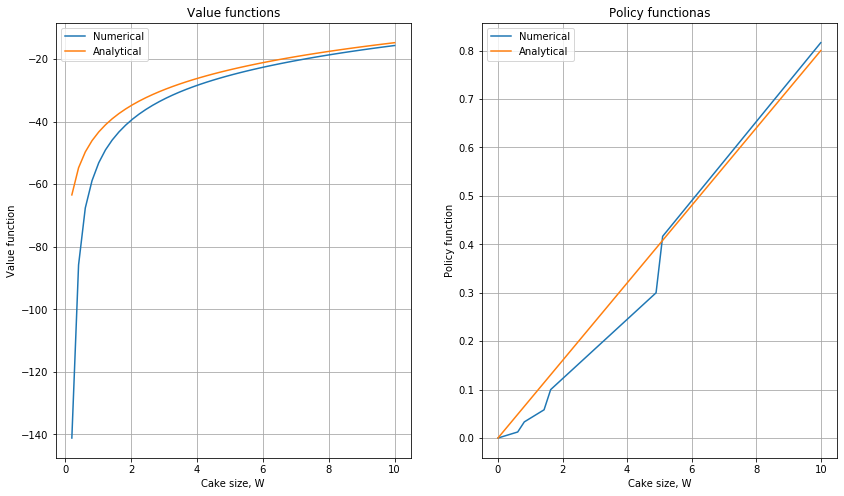

Accuracy with linear interpolation is 1155.1284306808527


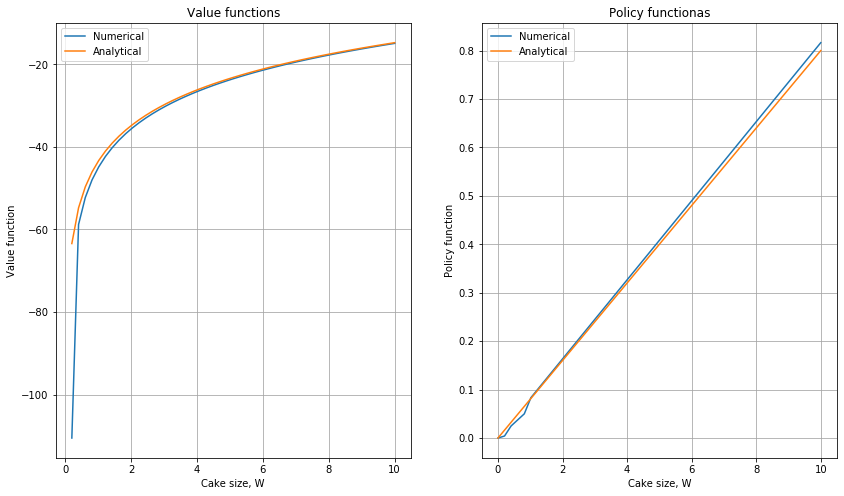

Accuracy with quadratic interpolation is 977.0216520877642


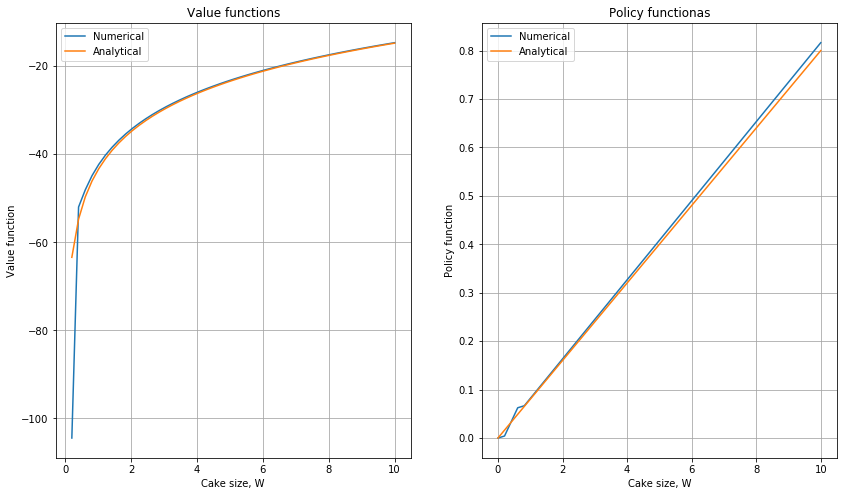

Accuracy with cubic interpolation is 951.9455344249233


/usr/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


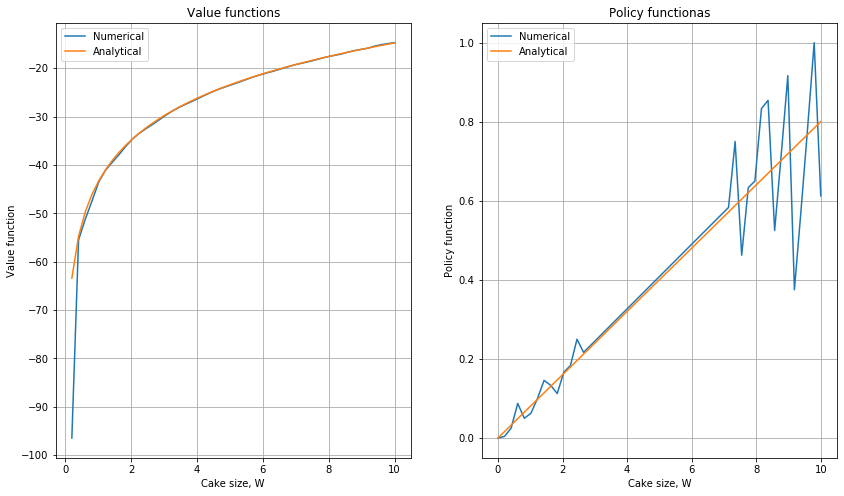

Accuracy with polynomial interpolation is 923.3203384734414


In [10]:
for knd in 'linear','quadratic','cubic','polynomial':
    V,c = m.solve(choice_bound=True,interpolation=knd)
    ac=accuracy(m,V=V,policy=c)
    print('Accuracy with '+knd+' interpolation is',ac)

## Task 5. Convergence to true solution

Make a plot of the accuracy measure as function of number of grid points (assuming
the number of grid points on choice grid is 2 times that of the states) for each of the four
interpolation schemes, with and without the bounding of the choices

On the separate axes plot the same curve under the assumption that the number of grid
points on the choice grid is 10 time larger than the state grid, for each of the 4
interpolation schemes, with and without the bounding of the choices

What is the best way to improve the accuracy of the solution?

In [11]:
# write your code here

......|......|......|......|......|......|No convergence: maximum number of iterations achieved!
..

/usr/lib/python3.7/site-packages/numpy/polynomial/polyutils.py:667: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))


.

/usr/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1087: RuntimeWarning: overflow encountered in multiply
  v[i] = v[i-1]*x
/usr/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/lib/python3.7/site-packages/numpy/polynomial/polyutils.py:671: RuntimeWarning: invalid value encountered in true_divide
  c, resids, rank, s = np.linalg.lstsq(lhs.T/scl, rhs.T, rcond)


ValueError: On entry to DLASCL parameter number 4 had an illegal value

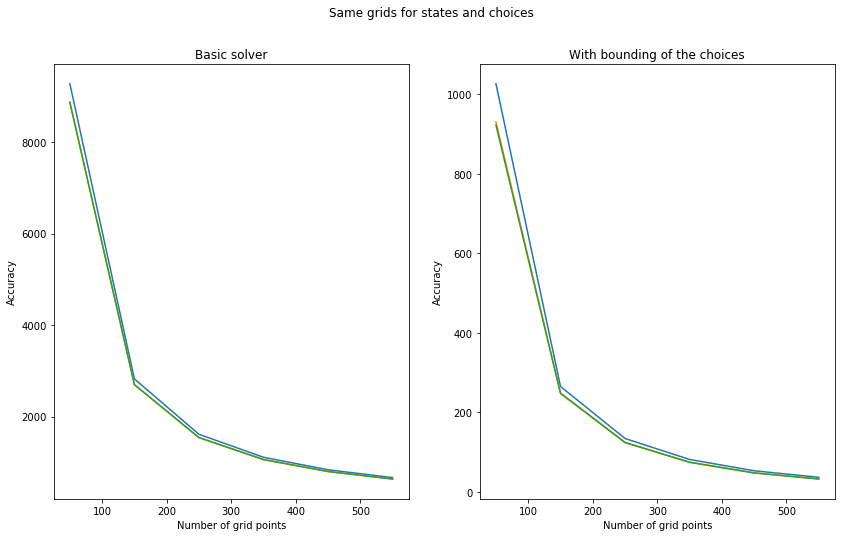

In [12]:
fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
fig1.suptitle('Same grids for states and choices')
ax1.set_title('Basic solver')
ax2.set_title('With bounding of the choices')
ax1.set_xlabel('Number of grid points')
ax2.set_xlabel('Number of grid points')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')
grids = np.arange(50,551,100,dtype='int')
for knd in 'linear','quadratic','cubic','polynomial':
    line = np.empty(grids.size)
    for i in range(grids.size):
        K = grids[i]
        m = cake_discretized(beta=0.92,Wbar=10,ngrid_state=K,ngrid_choice=2*K)
        V,c = m.solve(choice_bound=False,interpolation=knd)
        line[i]=accuracy(m,V=V,policy=c,plot=False)
        print('.',end='')
    ax1.plot(grids,line,label=knd+' interpolation')
    print('|',end='')
    for i in range(grids.size):
        K = grids[i]
        m = cake_discretized(beta=0.92,Wbar=10,ngrid_state=K,ngrid_choice=2*K)
        V,c = m.solve(choice_bound=True,interpolation=knd)
        line[i]=accuracy(m,V=V,policy=c,plot=False)
        print('.',end='')
    ax2.plot(grids,line,label=knd+' interpolation')
    print('|',end='')
ax1.legend()
ax2.legend()
plt.show()